In [1]:
results_directory="/private/home/marialomeli/LASER/tasks/bucc/embed"
# load candidate.tsv files and compute precision and recall to plot the P/R curve
# can just run bucc.py with the given file name and collect the output
# we don't need to run for all values of k, we can reuse one of the files 
# with lots of neighbours and select a subset 
powers_of_two = [2**p for p in range(1,8)]
flat1 =[f"sonar.k{neigh}.bucc2018.de-en.train.candidates.tsv" for neigh in powers_of_two]
flat =[f"sonar_difference.k{neigh}.bucc2018.de-en.train.candidates.tsv" for neigh in powers_of_two]
pq_64 = ["sonar64.bucc2018.de-en.train.candidates.tsv","sonar64.k16.bucc2018.de-en.train.candidates.tsv","sonar64.k100.bucc2018.de-en.train.candidates.tsv","sonar64.k120.bucc2018.de-en.train.candidates.tsv"]
#files = {"flat":flat,"pq64":pq_64}
files = {"ratio":flat1,"difference":flat}
print(files)

{'ratio': ['sonar.k2.bucc2018.de-en.train.candidates.tsv', 'sonar.k4.bucc2018.de-en.train.candidates.tsv', 'sonar.k8.bucc2018.de-en.train.candidates.tsv', 'sonar.k16.bucc2018.de-en.train.candidates.tsv', 'sonar.k32.bucc2018.de-en.train.candidates.tsv', 'sonar.k64.bucc2018.de-en.train.candidates.tsv', 'sonar.k128.bucc2018.de-en.train.candidates.tsv'], 'difference': ['sonar_difference.k2.bucc2018.de-en.train.candidates.tsv', 'sonar_difference.k4.bucc2018.de-en.train.candidates.tsv', 'sonar_difference.k8.bucc2018.de-en.train.candidates.tsv', 'sonar_difference.k16.bucc2018.de-en.train.candidates.tsv', 'sonar_difference.k32.bucc2018.de-en.train.candidates.tsv', 'sonar_difference.k64.bucc2018.de-en.train.candidates.tsv', 'sonar_difference.k128.bucc2018.de-en.train.candidates.tsv']}


In [2]:
import subprocess
import itertools
import os
os.chdir("/private/home/marialomeli/LASER/tasks/bucc")
thresholds = {"ratio":[],"difference":[]}
precisions= {"ratio":[],"difference":[]}
recalls = {"ratio":[],"difference":[]}
F1 =  {"ratio":[],"difference":[]}
for index_string in files.keys():
    for filename in files[index_string]:
        command = ['python', 'bucc.py','--src-lang','de','--trg-lang','en','--bucc-texts','./embed/bucc2018.de-en.train.txt','--bucc-ids','./embed/bucc2018.de-en.train.id','--candidates','./embed/'+filename,'--gold','./bucc2018/de-en/de-en.training.gold','--verbose']
        output = subprocess.check_output(command, universal_newlines=True)
        print(output)
        allbits=output.split('\n')
        helper = [bit.split(',') for bit in allbits[4].split('=')]
        all_metrics = list(itertools.chain.from_iterable(helper))
        thresholds[index_string].append(float(all_metrics[1]))
        precisions[index_string].append(float(all_metrics[3]))
        recalls[index_string].append(float(all_metrics[5]))
        F1[index_string].append(float(all_metrics[7]))

print(thresholds,recalls,precisions,F1)

LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.k2.bucc2018.de-en.train.candidates.tsv
 - optimizing threshold on gold alignments ./bucc2018/de-en/de-en.training.gold
 - best threshold=1.183773, precision=93.21, recall=90.73, F1=91.95

LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.k4.bucc2018.de-en.train.candidates.tsv
 - optimizing threshold on gold alignments ./bucc2018/de-en/de-en.training.gold
 - best threshold=1.352864, precision=93.27, recall=91.12, F1=92.18

LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.k8.bucc2018.de-en.train.candidates.tsv
 - optimizing threshold on gold alignments ./bucc2018/de-en/de-en.training.gold
 - best threshold=1.493512, precision=92.50, recall=91.27, F1=91.88

LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.k16.bucc2018.de-en.train.candida

In [4]:
print(thresholds)

{'ratio': [1.183773, 1.352864, 1.493512, 1.633303, 1.738006, 1.849561, 1.961005], 'difference': [0.100404, 0.162489, 0.214015, 0.248439, 0.274612, 0.293824, 0.328099]}


ratio
difference


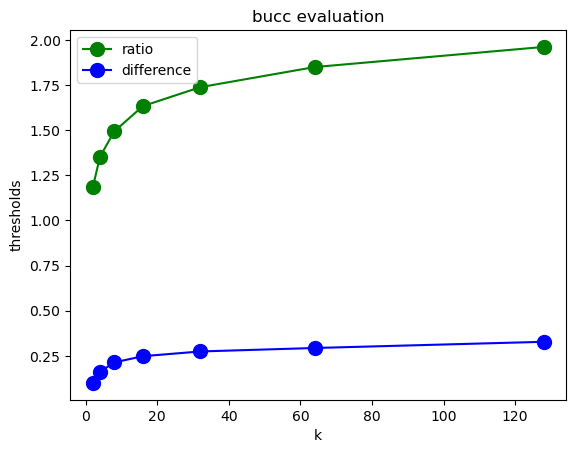

In [3]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]
colors = ["g", "b", "r", "m", "y", "c"]  #'k' for baseline
index_strings =["ratio","difference"]

for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two, thresholds[file], "o-", markersize=10, color=colors[i], label=index_strings[i])
#plt.xscale("log")
plt.xlabel("k")
plt.ylabel("thresholds")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

ratio
difference


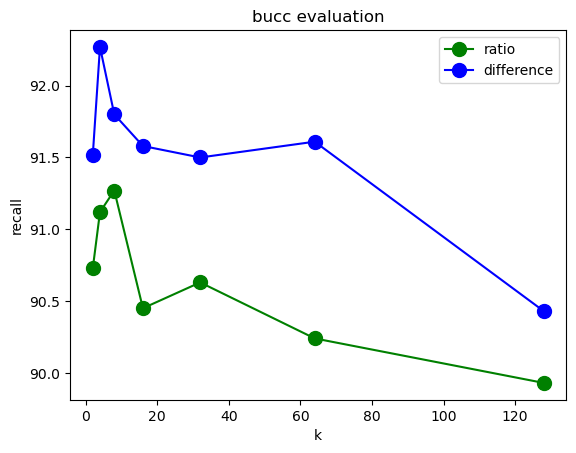

In [4]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]
colors = ["g", "b", "r", "m", "y", "c"]  #'k' for baseline
index_strings =["IndexFlat"]
for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two, recalls[file], "o-", markersize=10, color=colors[i], label=file)

    #plt.plot(powers_of_two,recalls["ratio"], "o-", markersize=10, color=colors[2],label=index_strings[0])
#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("recall")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

ratio
difference


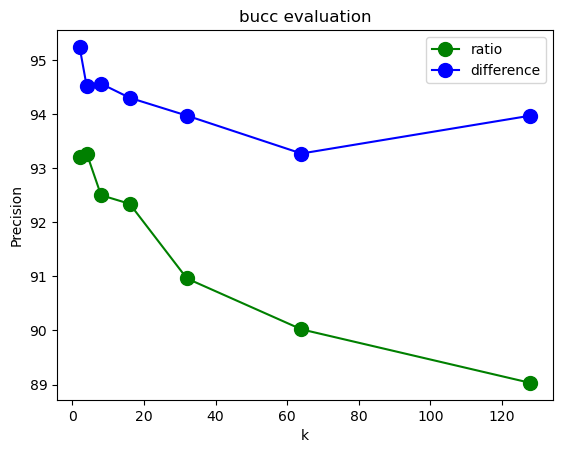

In [5]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]
colors = ["g", "b", "r", "m", "y", "c"]  #'k' for baseline
index_strings =["IndexFlat"]
for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two,precisions[file], "o-", markersize=10, color=colors[i],label=file)
#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("Precision")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

ratio
difference


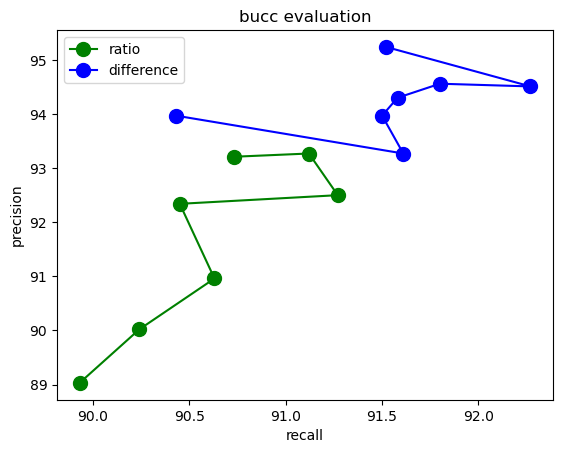

In [6]:
colors = ["g", "b", "r", "m", "y", "c"]  #'k' for baseline
index_strings =["IndexFlat"]

for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(recalls[file],precisions[file], "o-", markersize=10, color=colors[i], label=file)
#plt.xscale("log")
plt.ylabel("precision")
plt.xlabel("recall")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

ratio
difference


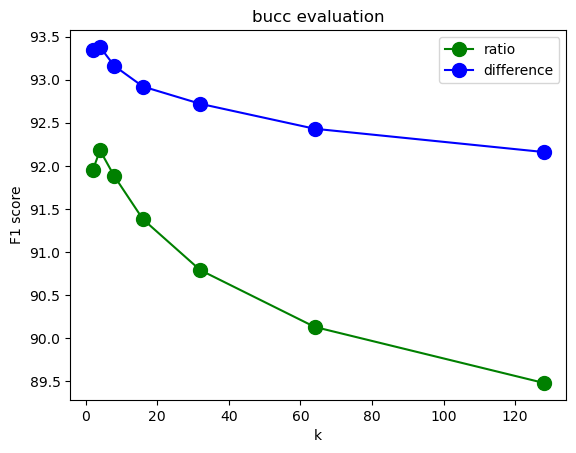

In [13]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]
colors = ["g", "b", "r", "m", "y", "c"]  #'k' for baseline
index_strings =["IndexFlat"]
for i,file in enumerate(["ratio","difference"]):
    print(file)
    plt.plot(powers_of_two,F1[file], "o-", markersize=10, color=colors[i],label=file)

#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("F1 score")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

In [ ]:
# PR curve for each threshold for each k, see BuccOptimize for collecting this